In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

import torch
import torchaudio
from torch.utils.data import DataLoader,Dataset
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Wav2Vec2ForSequenceClassification,Trainer,TrainingArguments

warnings.filterwarnings('ignore')

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
len(paths)
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.tail()

,speech,label
2795,/content/drive/MyDrive/Colab Notebooks/TESS To...,angry
2796,/content/drive/MyDrive/Colab Notebooks/TESS To...,angry
2797,/content/drive/MyDrive/Colab Notebooks/TESS To...,angry
2798,/content/drive/MyDrive/Colab Notebooks/TESS To...,angry
2799,/content/drive/MyDrive/Colab Notebooks/TESS To...,angry


In [4]:
df['label'].value_counts()

,count
label,
sad,400
fear,400
neutral,400
happy,400
ps,400
angry,400
disgust,400


<Axes: xlabel='label', ylabel='count'>

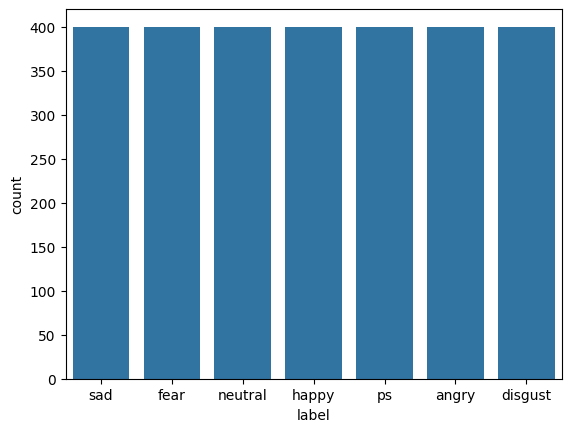

In [5]:
sns.countplot(data=df, x='label')

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

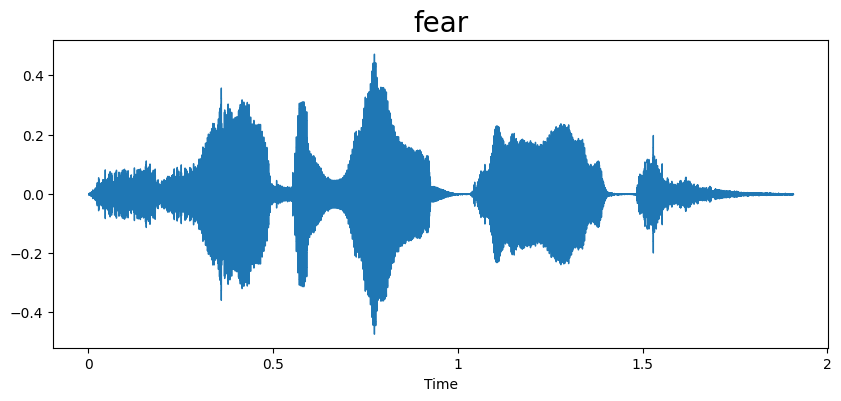

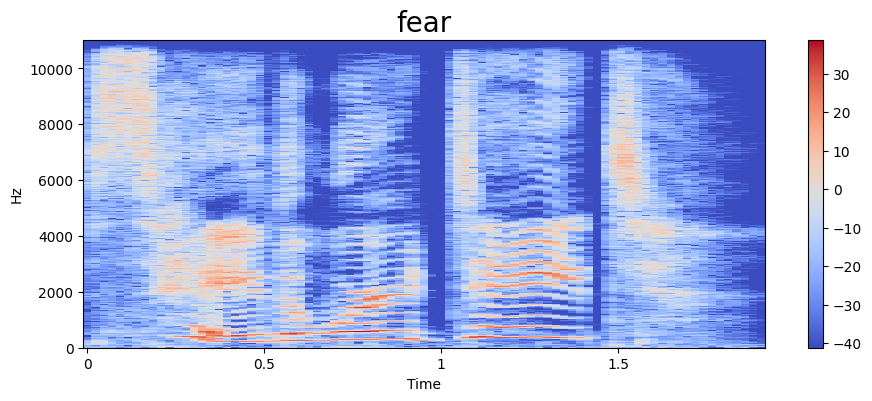

In [9]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

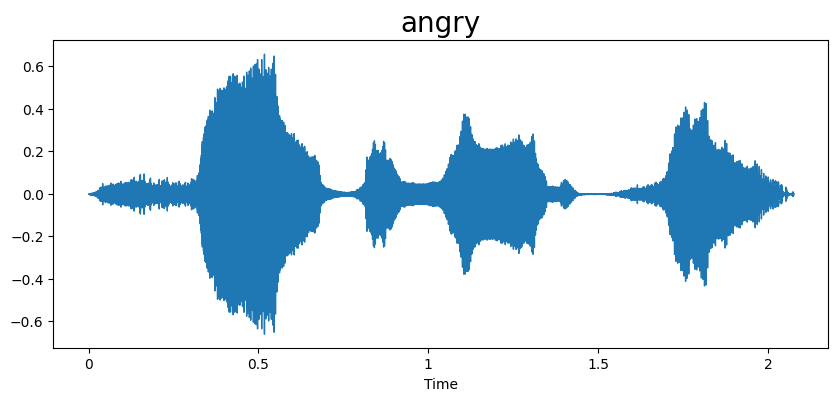

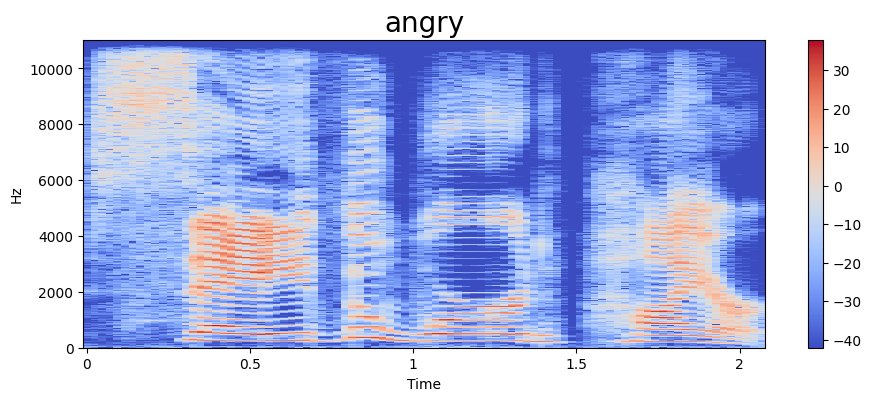

In [10]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

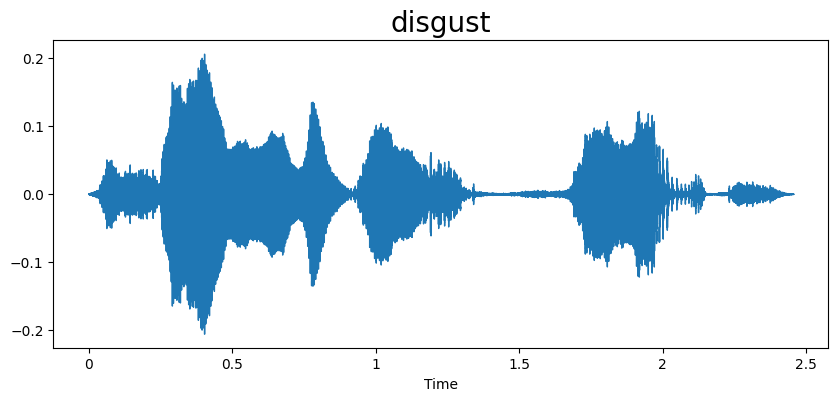

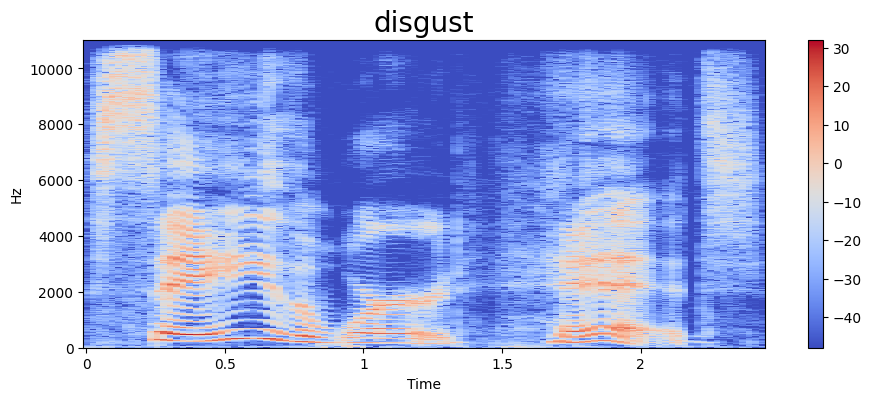

In [7]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

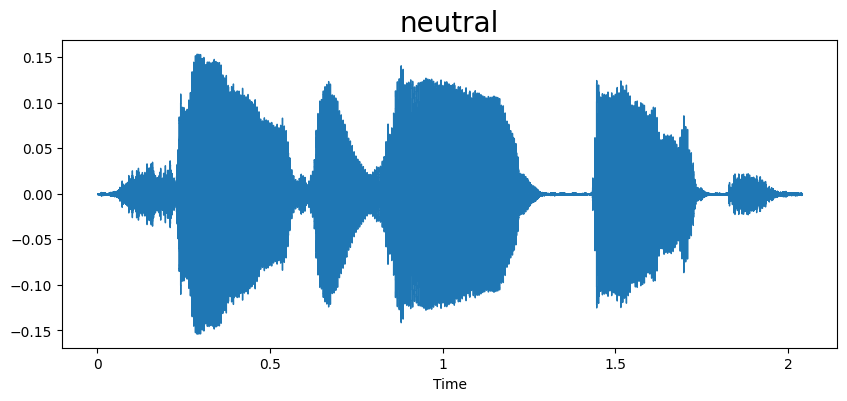

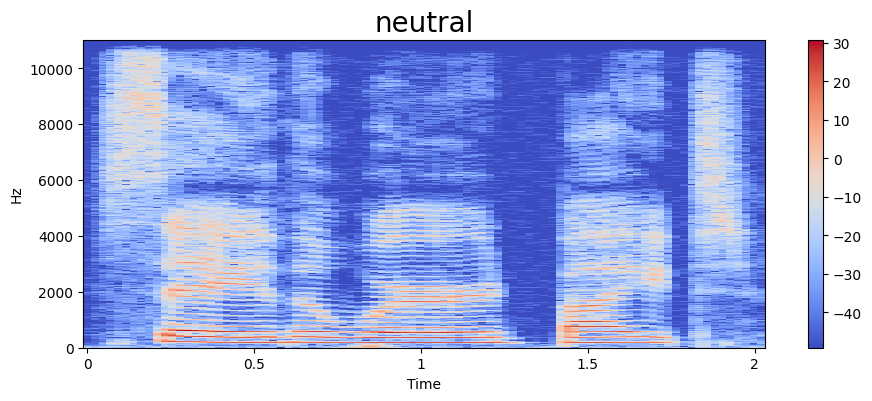

In [12]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

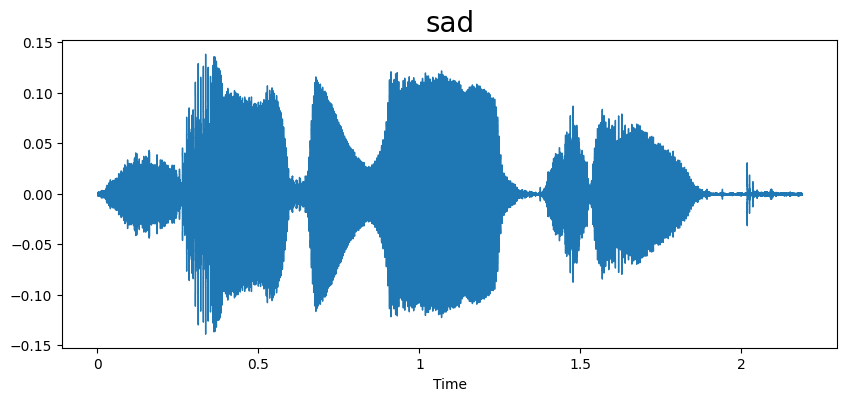

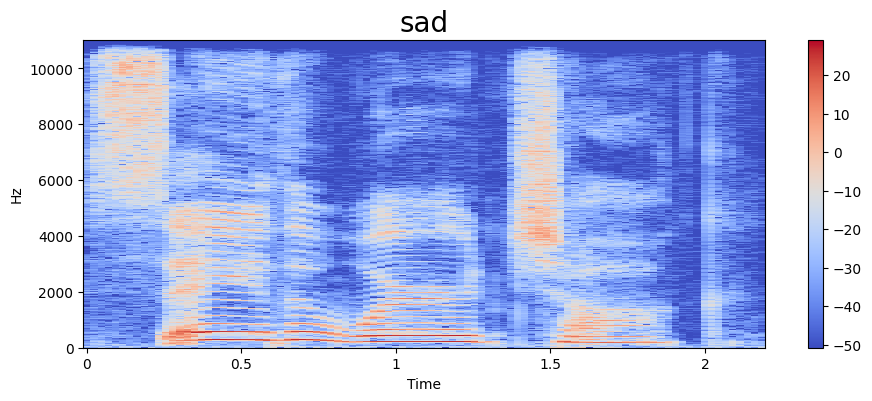

In [13]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

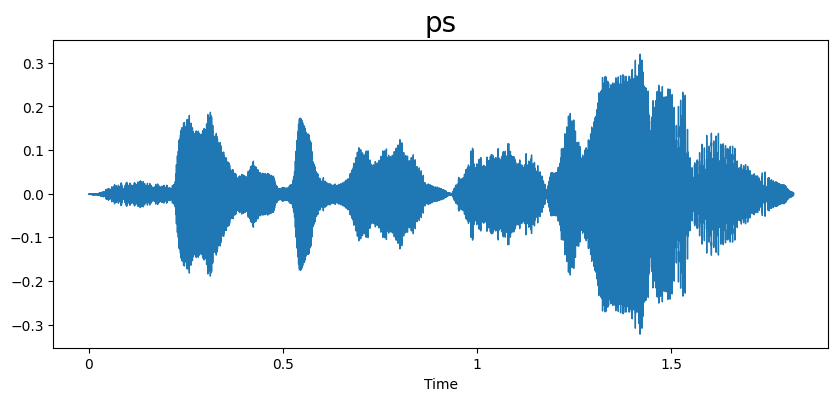

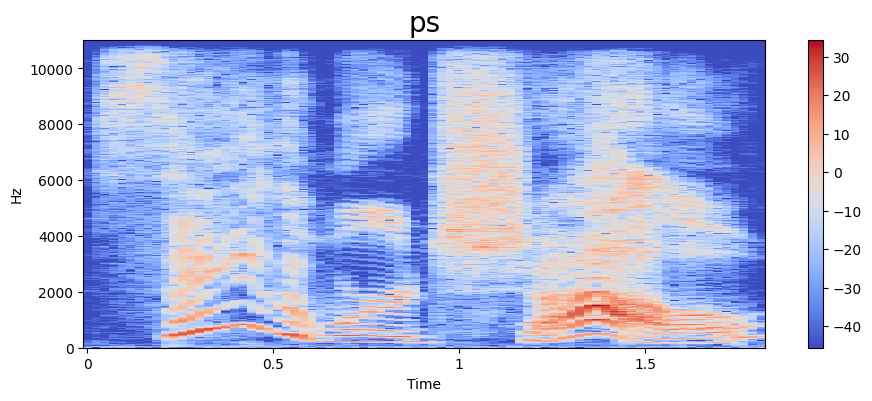

In [14]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

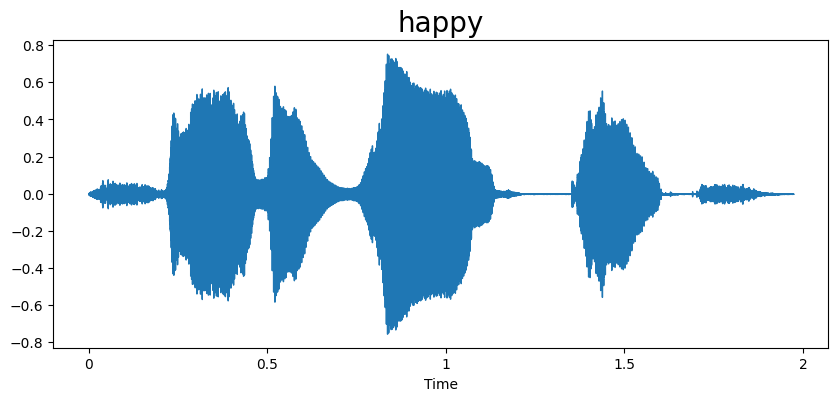

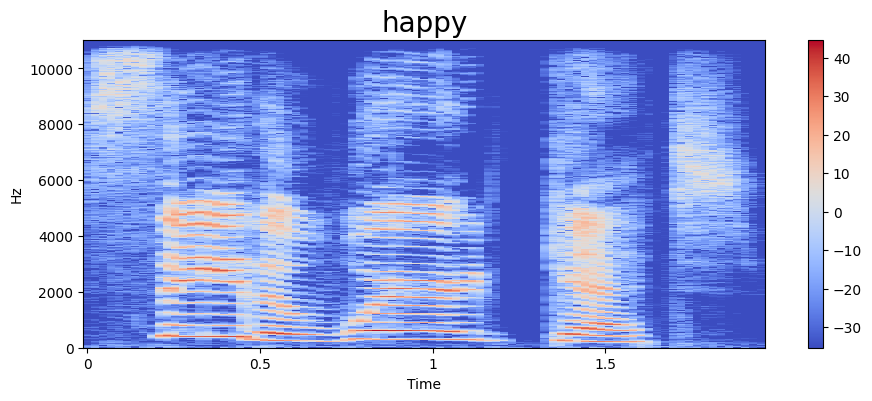

In [11]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
label_map = {label: idx for idx, label in enumerate(df["label"].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df["label"] = df["label"].map(label_map)
df.head(2)

,speech,label
0,/content/drive/MyDrive/Colab Notebooks/TESS To...,0
1,/content/drive/MyDrive/Colab Notebooks/TESS To...,0


In [9]:


class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['speech']
        label = self.df.iloc[idx]['label']

        # Load and process audio
        speech,sr = librosa.load(audio_path, sr=16000)

        # Pad or truncate to fixed length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Use processor (e.g., Wav2Vec2Processor) to convert to input tensors
        inputs = self.processor(speech, sampling_rate=16000, return_tensors="pt", padding=True, truncate=True, max_length=self.max_length)


        return {
            "input_values": inputs.input_values.squeeze(0),
            #"attention_mask": inputs.attention_mask.squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
processor= Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
train_df = SpeechEmotionDataset(train_df, processor)
test_df = SpeechEmotionDataset(test_df, processor)

In [13]:
train_df[0]

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


{'input_values': tensor([-0.0022, -0.0050, -0.0010,  ...,  0.2635,  0.2106,  0.1696]),
 'labels': tensor(2)}

In [14]:
train_dataloader = DataLoader(train_df, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=8, shuffle=False)


In [21]:
import os
os.makedirs("/content/output", exist_ok=True)


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/output",  # Where to save model checkpoints
    logging_dir="/content/logs",   # Where to write logs (TensorBoard, etc.)
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [30]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=test_df,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.604975,0.987500,0.987435,0.988411,0.987500
2,No log,0.213367,1.000000,1.000000,1.000000,1.000000
3,No log,0.159730,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.6478466215587798, metrics={'train_runtime': 1354.3777, 'train_samples_per_second': 4.962, 'train_steps_per_second': 0.31, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6478466215587798, 'epoch': 3.0})

In [27]:
!pip install wandb


In [32]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.15973007678985596, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 10.3713, 'eval_samples_per_second': 53.995, 'eval_steps_per_second': 3.375, 'epoch': 3.0}


In [63]:
import random
idx = random.randrange(0, len(test_df))
print('Original label:', inverse_label_map[test_df[idx]['labels'].item()])
print('Predicted label:', np.argmax(trainer.predict((test_df[idx],)).predictions))

input_values = test_df[idx]['input_values'].unsqueeze(0).to('cuda')
labels = test_df[idx]['labels'].unsqueeze(0)

with torch.no_grad():
    logits = model(input_values).logits

predicted_class = torch.argmax(logits, dim=1).item()
print('Predicted class:', inverse_label_map[predicted_class])

Original label: angry


Predicted label: 5
Predicted class: angry
